# PASSO 01 - TRATAMENTO DA BASE DE ACORDO COM O ROTEIRO

## 1.1 imports:

In [2]:
# bibliotecas:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import missingno as msno

In [3]:
# dataset:

df = pd.read_csv('cs_bisnode_panel.csv')

## 1.2. Tratamentos iniciais

In [4]:
df1 = df.copy()

# removendo colunas 'COGS', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages', 'D':
df1 = df1.drop(['COGS', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages', 'D'], axis=1)

# removendo dados do ano de 2016 da coluna year:
df1 = df1[df1['year']!=2016]

In [5]:
df.size

13815792

In [6]:
df1.size

11679612

## 1.3 Tratar os missing values de sales: excluir do dataset as empresas que tenham pelo menos 1 missing value em ao menos um ano dos dados.

### 1.3.0 Criei uma lista para saber quantos comp_ids unicos temos no total

In [8]:
#uma lista com todos os comp_ids unicos
comp_ids = df1['comp_id'].unique()
comp_ids.size

46412

#### 1.3.1 Check quantos são os comp_id que possuem missing values em sales

In [ ]:
#lista com os comp_ids que na coluna sales possuem missing values
comp_ids_missing = df1[df1['sales'].isnull()]['comp_id'].unique()
comp_ids_missing.size


4650

#### 1.3.2 (Double Check)
##### Criei para fins de validação um teste de redundancia para testar se excluindo os dados de sales eu excluiria os comp_ids tb

In [ ]:
#criar um dataset com os comp_id que possuem missing values em sales
df1_missing_sales = df1[df1['sales'].isnull()]['comp_id'].unique()
df1_missing_sales = pd.DataFrame(df1_missing_sales, columns=['comp_id'])
df1_missing_sales.size


4650

#### 1.3.3 Remover de df1 os comp_id que possuam missing values em sales e coloca-los no df2

In [ ]:
#retirar todos os comp_ids_missing do df1 e insireir no df2 os dados restantes
df2 = df1[~df1['comp_id'].isin(comp_ids_missing)]
df2.size

10509156

In [ ]:
df2[df2['sales']==0].size

1431108

### 1.3.4 (Double Check)
#### Verificação para saber se a remoção dos dados ocorreu bem

In [ ]:
#Verifica através de uma contagem de sales com missing values
df2['sales'].isnull().sum()

0

In [ ]:
#uma lista com todos os comp_ids unicos
comp_ids2 = df2['comp_id'].unique()
comp_ids2.size

41762

## 1.4 Para sales, considerar os valores negativos como zero: primeiro, há poucos valores negativos. Segundo, pode representar um erro. "Logo, substituir esses missing values por zero não tratará prejuízo ao modelo"

#### 1.4.0 Verificar o número de sales negativas que possuimos no DF

In [ ]:
#verificar o numero de comp_id com valores de sales negativas
df2[df2['sales']<0]['comp_id'].unique().size

36

#### 1.4.1 Transformar as vendas negativas em 0

In [ ]:
#Tranformas as Sales negativas em 0
df2['sales'] = df2['sales'].apply(lambda x: 0 if x < 0 else x)

C:\Users\tiago\AppData\Local\Temp\ipykernel_29316\1928248006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['sales'] = df2['sales'].apply(lambda x: 0 if x < 0 else x)


## 1.5. Criar variável resposta

Variável "will_close" que indique se a empresa não possui vendas no ano seguinte *E* no próximo, desde que ela apresente venda no ano atual.

*** Fazer condição para verificar se ela volta a ter vendas depois de ter fechado por 2 anos? ***

Opinião Tiago: Não tenho interesse em saber se a empresa abriu após ter fechado, uma vez que o motivo da reabertura pode ser diverso e não temos a informação. O que acham?


In [ ]:
# Variável "will_close" que indique se a empresa não possui vendas no ano seguinte *E* no próximo.

# Ordenar por 'comp_id' e 'year' para utilização da função shift:
df2 = df2.sort_values(['comp_id', 'year'])

df2['will_close'] = np.where(
    (df2['sales'] > 0) 
    & 
    (df2.groupby('comp_id')['sales'].shift(-1) <= 0) 
    & 
    (df2.groupby('comp_id')['sales'].shift(-2) <= 0), 1, 0)

# Verificando se a variável foi criada corretamente:
df2[['comp_id', 'year','sales', 'will_close']].head(11).sort_values('comp_id')



,comp_id,year,sales,will_close
0,1001034.0,2005,62751.851562,0
1,1001034.0,2006,64625.925781,0
2,1001034.0,2007,65100.000000,0
3,1001034.0,2008,78085.187500,0
4,1001034.0,2009,45388.890625,0
5,1001034.0,2010,9929.629883,1
6,1001034.0,2011,0.000000,0
7,1001034.0,2012,0.000000,0
8,1001034.0,2013,0.000000,0
9,1001034.0,2014,0.000000,0


In [ ]:
# filtrando apenas empresas do ano de 2012:
df2 = df2[df2['year']==2012]

In [ ]:
# tratando valores negativos da coluna sales utilizando np.where para trocar valores negativos por 0:
df2['sales'] = np.where(df2['sales']<0, 0, df2['sales'])

In [ ]:
# criando coluna em log da variável sales:
df2['log_sales'] = np.log(df2['sales'])

c:\Users\tiago\anaconda3\envs\Insper_Computacao_para_DS\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# # criando coluna company_age subtraindo founded_year e year:
df2['company_age'] = df2['year'] - df2['founded_year']

In [ ]:
# filtrando empresas que possuem revenue abaixo de 10.000.000 e acima de 1.000 euros:
df2 = df2[(df2['sales'] > 1000) & (df2['sales'] < 10000000)]

In [ ]:
# retirando empresas que apresentaram sales == 0 da base, pois ela não é útil para verificarmos se a empresa irá fechar em 2 anos ou não:
df2 = df2[df2['sales'] != 0]

In [ ]:
df2['sales'].describe()

,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,intang_assets,inventories,...,ceo_count,foreign,female,birth_year,inoffice_days,urban_m,labor_avg,will_close,log_sales,company_age
count,2.043700e+04,2.046200e+04,2.046200e+04,2.047200e+04,2.047200e+04,2.047200e+04,2.046200e+04,2.047200e+04,2.046200e+04,2.046200e+04,...,18551.000000,18551.000000,18551.000000,15879.000000,18551.000000,20472.000000,17575.000000,20472.000000,20472.000000,18549.000000
mean,9.443816e+03,1.044987e+05,9.045782e+04,1.291387e+03,2.520820e+03,1.226014e+03,1.543532e+05,6.467392e+03,4.099970e+03,2.697612e+04,...,1.288556,0.095299,0.257531,1965.384533,3065.514046,2.084457,0.636054,0.029797,10.743667,8.999353
std,5.054804e+04,4.743192e+05,5.258306e+05,1.193551e+05,1.237666e+05,3.183766e+04,1.185493e+06,1.299708e+05,6.876789e+04,2.080934e+05,...,0.545521,0.280536,0.401992,11.340996,1736.103186,0.844542,1.624451,0.170030,1.714730,6.966106
min,-1.489630e+04,-3.460000e+04,-8.759259e+03,-1.418519e+03,-1.740741e+02,-2.888889e+05,0.000000e+00,-1.091879e+07,-2.962963e+01,-2.607407e+03,...,1.000000,0.000000,0.000000,1920.000000,10.000000,1.000000,0.083333,0.000000,6.911452,0.000000
25%,1.333333e+02,3.370370e+03,3.660185e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.453704e+02,-6.233333e+03,0.000000e+00,0.000000e+00,...,1.000000,0.000000,0.000000,1957.000000,1887.000000,1.000000,0.097222,0.000000,9.603883,2.000000
50%,9.111111e+02,1.158889e+04,1.437963e+04,0.000000e+00,0.000000e+00,0.000000e+00,4.694445e+03,2.592592e+02,0.000000e+00,1.155556e+03,...,1.000000,0.000000,0.000000,1966.500000,2632.000000,2.000000,0.229167,0.000000,10.670161,8.000000
75%,4.070370e+03,4.060371e+04,4.769907e+04,0.000000e+00,0.000000e+00,0.000000e+00,4.001759e+04,4.114815e+03,0.000000e+00,7.187037e+03,...,2.000000,0.000000,0.500000,1974.000000,3696.500000,3.000000,0.520833,0.000000,11.809877,15.000000
max,3.570863e+06,2.066350e+07,4.186429e+07,1.704172e+07,1.709232e+07,3.253704e+06,1.036673e+08,4.378226e+06,5.630704e+06,1.725857e+07,...,15.000000,1.000000,1.000000,2015.000000,10041.000000,3.000000,42.118057,1.000000,16.117026,32.000000


## 1.5 Criação da coluna da idade da empresa 

In [ ]:
# Define uma função para preencher NaN com o primeiro valor não NaN, ou NaN se todos forem NaN
def fill_first_non_nan(series):
    non_nan_values = series.dropna()
    return non_nan_values.iloc[0] if not non_nan_values.empty else np.nan

# Preenche os valores NaN na coluna "founded_date" com base na função definida
df['founded_date'] = df.groupby('comp_id')['founded_date'].transform(fill_first_non_nan)

# Converte a coluna "founded_date" para o tipo datetime
df['founded_date'] = pd.to_datetime(df['founded_date'])

# Calcula a idade com base na coluna "year" e "founded_date"
df['comp_age'] = df['year'] - df['founded_date'].dt.year

## 1.6 Filtro de revenue da empresa e criação da coluna de porte da empresa

In [ ]:
# Pega a média de vendas de uma empresa durante os anos determinados
revenue = df.groupby('comp_id')['sales'].mean()

# Junta a coluna criada no dataframe original
df = df.merge(revenue, how="inner", on="comp_id").rename(columns={"sales_y": "revenue"})

#Condições para definir se a empresa é pequena, média ou grande
conditions = [(df["revenue"] <= 50000), 
              (df["revenue"] < 100000) & (df["revenue"] > 50000),
              (df["revenue"] >= 100000)]

choices = ["Pequena", "Média", "Grande"]

df["comp_size"] = np.select(conditions, choices, default=0)

In [ ]:
#Filtro para selecionar empresas com revenue maior que 1000 e menor que 10 MM
df = df[(df["revenue"] > 1000) & (df["revenue"] < 10000000)]

## 1.7 Criação da coluna de capital circulante líquido

*curr_assets* -> Ativos Circulantes

*curr_liab* -> Passivos Circulantes

Com esses dois valores, é possível calcular o **capital circulante líquido**, dividindo os ativos circulantes por passivos circulantes. Esse valor significa o quanto a empresa consegue pagar suas contas e dívidas no prazo correto.

É interessante fazer mais uma coluna com esse cálculo pois pode ser um dos motivos aos quais a empresa fechou.

Ex: Caso uma empresa tenha o valor de liquidez corrente igual a 2, significa que a cada R$ 1,00 de dívida, ela tem R$ 2,00 para abater essa dívida.

Então, empresas com valores menores que 1, significa que elas não conseguem abater a dívida naquele ano.

In [ ]:
df["curr_idx_liq"] = df["curr_assets"]/df["curr_liab"]

df.head()

,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,...,urban_m,region_m,founded_date,exit_date,labor_avg,Open_2012,comp_age,comp_size,revenue,curr_idx_liq
0,1001034.0,2005-01-01,2005-12-31,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,1229.629639,...,1,Central,1990-11-19,NaN,NaN,True,15.0,Pequena,29625.589577,0.959413
1,1001034.0,2006-01-01,2006-12-31,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,725.925903,...,1,Central,1990-11-19,NaN,NaN,True,16.0,Pequena,29625.589577,1.074613
2,1001034.0,2007-01-01,2007-12-31,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,1322.222168,...,1,Central,1990-11-19,NaN,NaN,True,17.0,Pequena,29625.589577,1.050807
3,1001034.0,2008-01-01,2008-12-31,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,1022.222229,...,1,Central,1990-11-19,NaN,NaN,True,18.0,Pequena,29625.589577,1.090433
4,1001034.0,2009-01-01,2009-12-31,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,814.814819,...,1,Central,1990-11-19,NaN,0.083333,True,19.0,Pequena,29625.589577,0.335754


# PASSO 02 - DESCRICAO DOS DADOS

## 2.1. Dimensão dos dados

In [ ]:
print( 'Numero de Linhas: {}'.format( df2.shape[0] ) )
print( 'Número de Colunas: {}'.format( df2.shape[1] ) )

Numero de Linhas: 20472
Número de Colunas: 45


## 2.2. Tipo dos dados


In [ ]:
df2.dtypes

comp_id                 float64
begin                    object
end                      object
amort                   float64
curr_assets             float64
curr_liab               float64
extra_exp               float64
extra_inc               float64
extra_profit_loss       float64
fixed_assets            float64
inc_bef_tax             float64
intang_assets           float64
inventories             float64
liq_assets              float64
material_exp            float64
personnel_exp           float64
profit_loss_year        float64
sales                   float64
share_eq                float64
subscribed_cap          float64
tang_assets             float64
balsheet_flag             int64
balsheet_length           int64
balsheet_notfullyear      int64
year                      int64
founded_year            float64
exit_year               float64
ceo_count               float64
foreign                 float64
female                  float64
birth_year              float64
inoffice

## 2.3. Mudando Tipo dos Dados

Vamos converter os tipos de dados algumas colunas para que estas esteja coerentes com as descrição das variáveis, a saber:

- comp_id: como é a identificação da empresa, deve ser considerada uma string (object)
- begin: converter para data
- end: converter para data
- founded_date: converter para data
- exit_date: converter para data
- nace_main: converter para string (object)
- ind2: converter para string (object)
- ind: converter para string (object)
- will_close: converter para int64

In [ ]:
df2['comp_id'] = df['comp_id'].astype('object')
df2['begin'] = pd.to_datetime(df['begin'],format="%Y-%m-%d", errors='coerce')
df2['end'] = pd.to_datetime(df['end'],format="%Y-%m-%d", errors='coerce')
df2['founded_date'] = pd.to_datetime(df['founded_date'],format="%Y-%m-%d", errors='coerce')
df2['exit_date'] = pd.to_datetime(df['exit_date'],format="%Y-%m-%d", errors='coerce')
df2['nace_main'] = df['nace_main'].astype('object')
df2['ind2'] = df['ind2'].astype('object')
df2['ind'] = df['ind'].astype('object')
df2['will_close'] = df2['will_close'].astype('int64')

## 2.4. Checando NA

<Axes: >

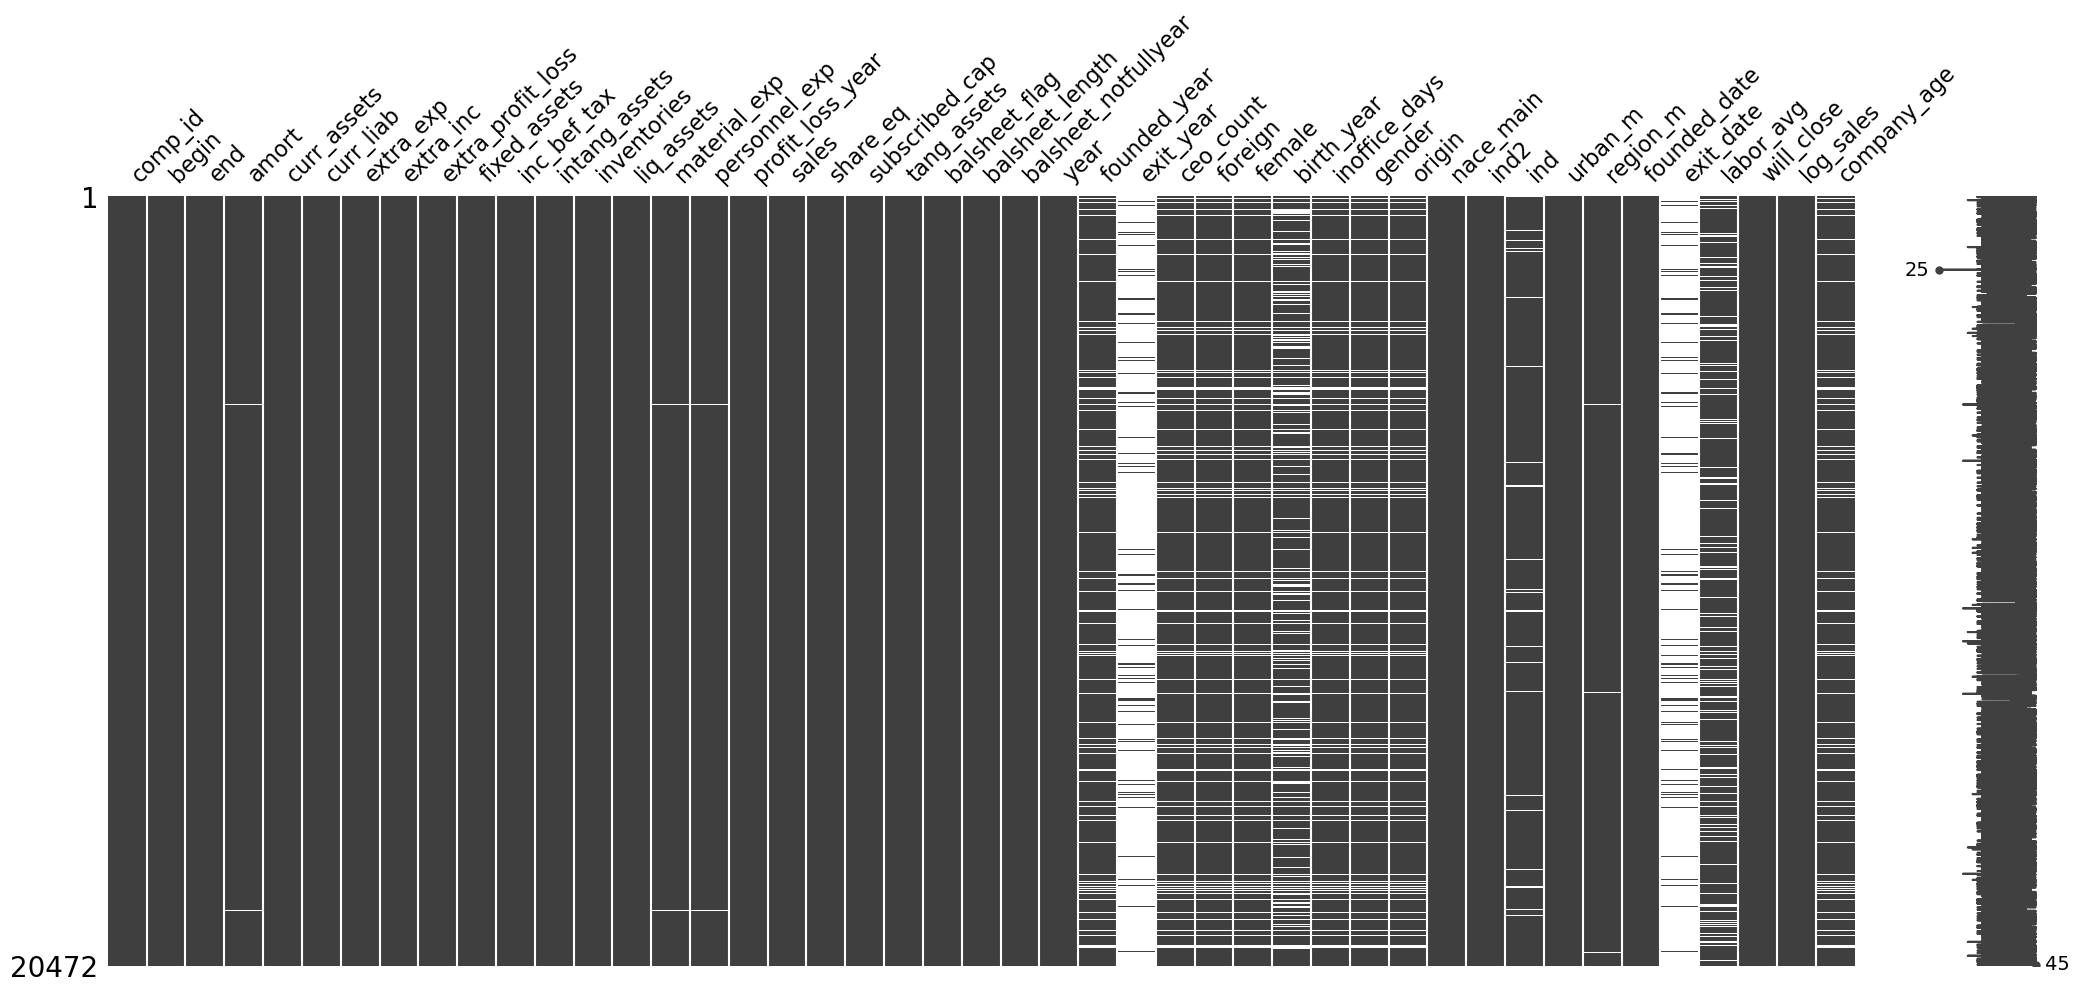

In [ ]:
import missingno as msno

msno.matrix(df2)

In [ ]:
missing_values = df2.isna().sum()
missing_values = pd.DataFrame({ 'Qtd_Valores_Faltantes': missing_values}).reset_index()
missing_values[missing_values['Qtd_Valores_Faltantes'] > 0]

,index,Qtd_Valores_Faltantes
16,profit_loss_year,10
18,share_eq,10
19,subscribed_cap,10
25,founded_year,1923
26,exit_year,18625
27,ceo_count,1921
28,foreign,1921
29,female,1921
30,birth_year,4593
31,inoffice_days,1921


## 2.5. Preenchendo NA

In [ ]:
# Considerar ZERO os missing values das variáveis "extra_exp", "extra_inc", "extra_profit_loss". 
# Como são gastos de natureza eventual, os missing values podem representar que não houve esse tipo de dado para o ano em questão;

df2['extra_exp'] = df2['extra_exp'].fillna(0)
df2['extra_inc'] = df2['extra_inc'].fillna(0)
df2['extra_profit_loss'] = df2['extra_profit_loss'].fillna(0)

# Subsitutir pela média da empresa as variáveis numéricas: 
# "amort", "curr_assets", "curr_liab", "fixed_assets", "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp", "tang_assets", "labor_avg". 
# São variáveis de natureza contábil e que tem um peso importante para explicar a saúde financeira da empresa. 
# Logo, substituir pela média da empresa mantém a distribuição dos dados intacta e utilizar por ZERO ou excluir os dados pode prejudicar a estimativa do modelo

df2['amort'] = df2['amort'].fillna(df2['amort'].mean())
df2['curr_assets'] = df2['curr_assets'].fillna(df2['curr_assets'].mean())
df2['curr_liab'] = df2['curr_liab'].fillna(df2['curr_liab'].mean())
df2['fixed_assets'] = df2['fixed_assets'].fillna(df2['fixed_assets'].mean())
df2['inc_bef_tax'] = df2['inc_bef_tax'].fillna(df2['inc_bef_tax'].mean())
df2['intang_assets'] = df2['intang_assets'].fillna(df2['intang_assets'].mean())
df2['inventories'] = df2['inventories'].fillna(df2['inventories'].mean())
df2['liq_assets'] = df2['liq_assets'].fillna(df2['liq_assets'].mean())
df2['material_exp'] = df2['material_exp'].fillna(df2['material_exp'].mean())
df2['personnel_exp'] = df2['personnel_exp'].fillna(df2['personnel_exp'].mean())
df2['tang_assets'] = df2['tang_assets'].fillna(df2['tang_assets'].mean())
df2['labor_avg'] = df2['labor_avg'].fillna(df2['labor_avg'].mean())


# Subsitutir pela média da empresa as variáveis: "urban_m", "region_m", "founded_date", 
# São variáveis não numéricas que podem ajudar na construção do modelo, pois podem ter a priori relevância na explicação da variável resposta.

df2['urban_m'] = df2['urban_m'].fillna(df2['urban_m'].mean())
df2['region_m'] = df2['region_m'].fillna(df2['region_m'].mode()) # ainda constam valores nulos. verificar o que está havendo
df2['founded_date'] = df2['founded_date'].fillna(df2['founded_date'].mean())

In [ ]:
missing_values[missing_values['Qtd_Valores_Faltantes'] > 0]

,index,Qtd_Valores_Faltantes
16,profit_loss_year,10
18,share_eq,10
19,subscribed_cap,10
25,founded_year,1923
26,exit_year,18625
27,ceo_count,1921
28,foreign,1921
29,female,1921
30,birth_year,4593
31,inoffice_days,1921


## 2.6. Análise Descritiva

In [ ]:
var_num = df1.select_dtypes( include=['int64', 'float64'] )
var_cat = df1.select_dtypes( exclude=['int64', 'float64','datetime64[ns]'] )

var_num.columns

Index(['comp_id', 'amort', 'curr_assets', 'curr_liab', 'extra_exp',
       'extra_inc', 'extra_profit_loss', 'fixed_assets', 'inc_bef_tax',
       'intang_assets', 'inventories', 'liq_assets', 'material_exp',
       'personnel_exp', 'profit_loss_year', 'sales', 'share_eq',
       'subscribed_cap', 'tang_assets', 'balsheet_flag', 'balsheet_length',
       'balsheet_notfullyear', 'year', 'founded_year', 'exit_year',
       'ceo_count', 'foreign', 'female', 'birth_year', 'inoffice_days',
       'nace_main', 'ind2', 'ind', 'urban_m', 'labor_avg', 'will_close',
       'log_sales', 'company_age'],
      dtype='object')

### 2.6.1. Atributos Numéricos

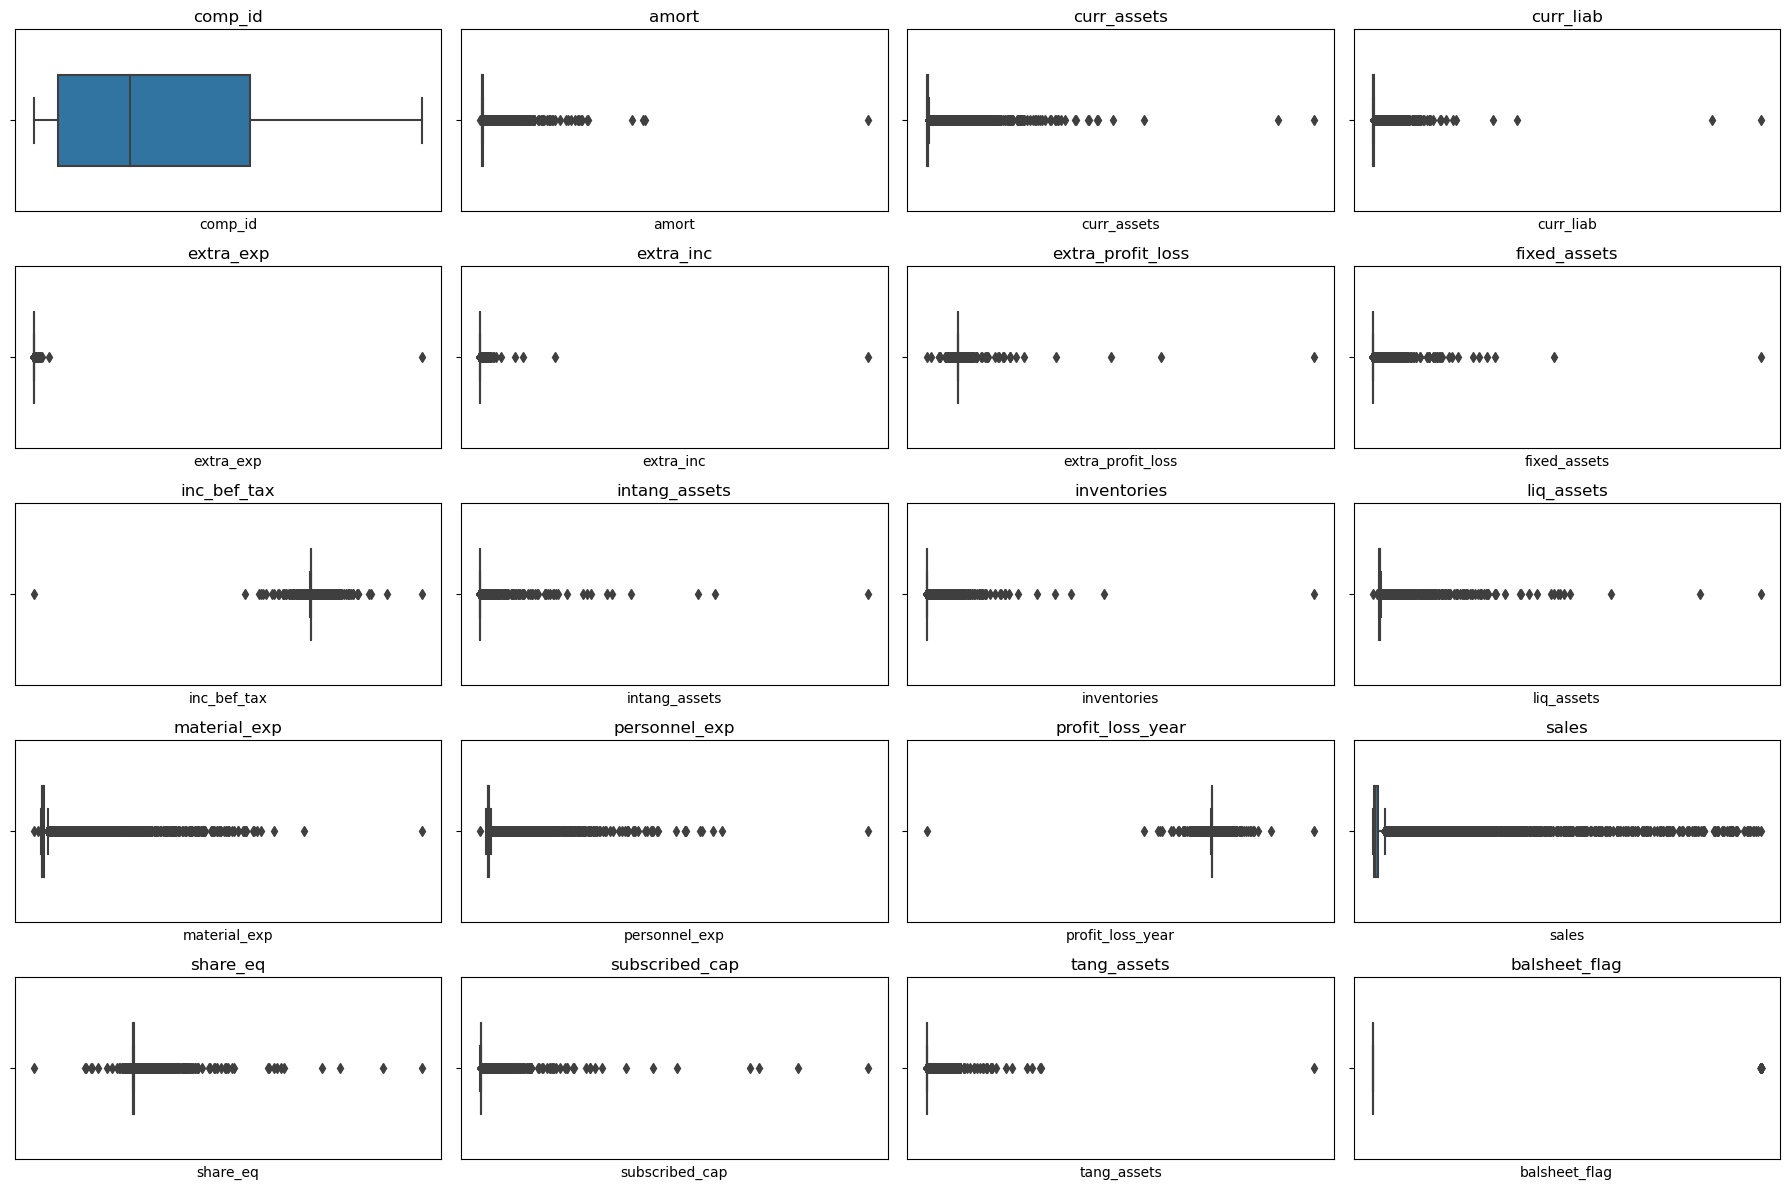

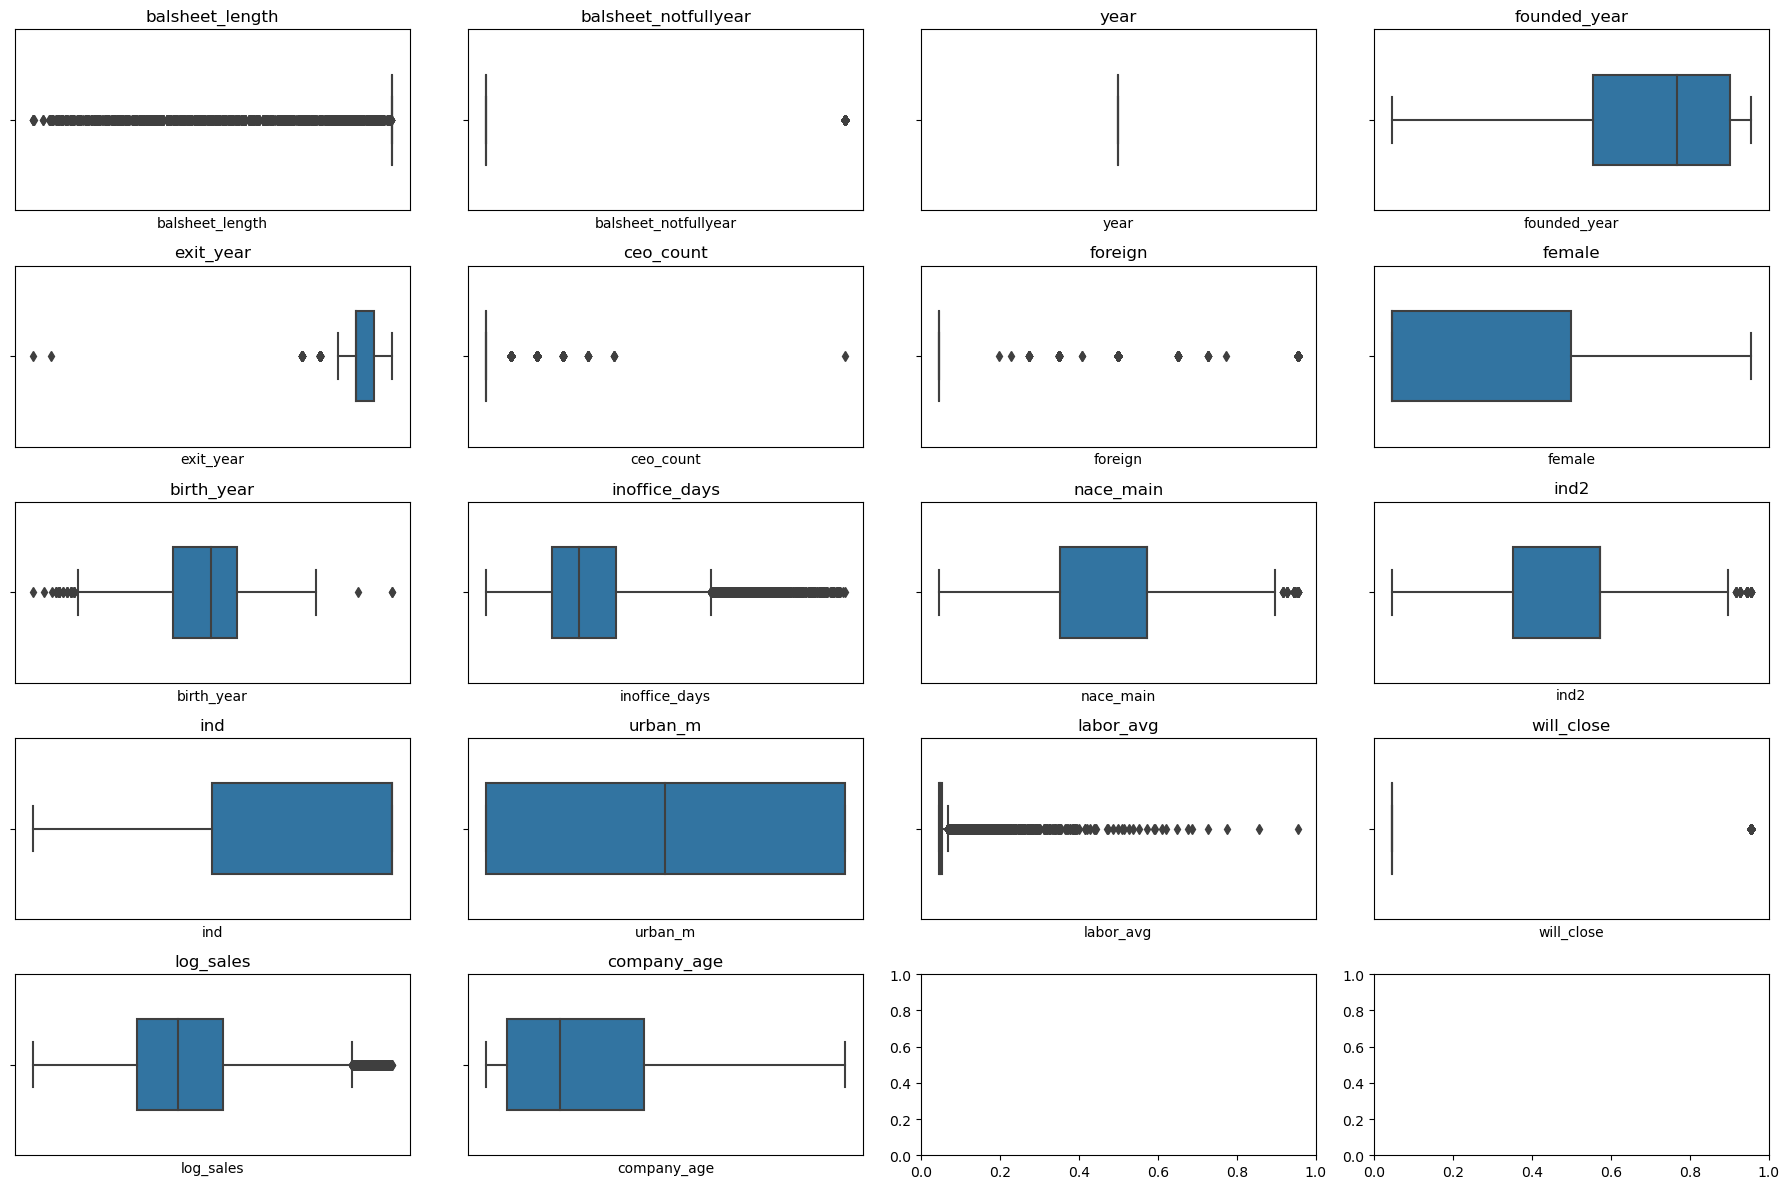

In [ ]:
# fazendo boxplot de todas as variáveis numéricas para identificar as distribuições:

colunas = var_num.columns

# Configurações para a disposição dos subplots
num_linhas = 5  
num_colunas = 4  

# Calcula o número total de figuras necessárias
num_total_figuras = (len(colunas) // (num_linhas * num_colunas)) + 1

# Tamanho da figura
tamanho_figura = (18, 12)

# Loop para criar cada figura com os boxplots
for figura_num in range(num_total_figuras):
    fig, axs = plt.subplots(num_linhas, num_colunas, figsize=tamanho_figura)
    
    # Colunas para esta figura
    inicio_coluna = figura_num * num_linhas * num_colunas
    fim_coluna = (figura_num + 1) * num_linhas * num_colunas
    colunas_figura = colunas[inicio_coluna:fim_coluna]

    # Iterar pelas colunas e criar os boxplots para esta figura
    for i, coluna in enumerate(colunas_figura):
        linha = i // num_colunas
        col = i % num_colunas
        sns.boxplot(x=var_num[coluna], ax=axs[linha, col], width=0.5)
        axs[linha, col].set_title(coluna)
        axs[linha, col].set_xticks([])  # Remove os rótulos do eixo x

    # Ajustar o layout
    plt.tight_layout()

    # Exibir a figura
    plt.show()

### 2.6.2. Atributos Categóricos

# PASSO 03 - FEATURE ENGINEERING

## 3.1. Mapa Mental de Hipoteses

## 3.2. Criacao das Hipoteses

### 3.2.1. Hipoteses Financeiras

1. Empresas com maior amortização tendem a manter-se abertas.
Justificação: Empresas que amortizam ativos de forma consistente podem estar investindo em atualizações de ativos e infraestrutura, o que pode contribuir para sua estabilidade financeira.

2. Empresas com maiores ativos circulantes (current assets) têm maior probabilidade de permanecer abertas.
Justificação: Um alto nível de ativos circulantes pode indicar uma capacidade maior de lidar com despesas de curto prazo e obrigações, o que é fundamental para a sobrevivência a curto prazo.

3. Empresas com dívidas de curto prazo (current liabilities) menores são mais propensas a permanecer abertas.
Justificação: Empresas com menos dívidas de curto prazo podem enfrentar menos pressão financeira e ter mais flexibilidade para cumprir suas obrigações.

4. Empresas com maiores despesas extras (extra_expenditures) têm maior risco de fechamento.
Justificação: Despesas extras elevadas podem indicar instabilidade financeira ou gastos não planejados, o que pode impactar negativamente a saúde financeira da empresa.

5. Empresas com receitas extras (extra income) mais consistentes têm menor probabilidade de fechar.
Justificação: Receitas extras podem contribuir para a estabilidade financeira, tornando a empresa mais capaz de enfrentar desafios.

6. Empresas com prejuízos extras (extra profit loss) frequentes têm maior probabilidade de fechar.
Justificação: Prejuízos extras podem indicar problemas financeiros contínuos que podem levar ao fechamento.

7. Empresas com maiores vendas domésticas líquidas (net domestic sales) têm menor probabilidade de fechar.
Justificação: Vendas domésticas sólidas podem indicar uma base de clientes estável e uma demanda consistente por produtos ou serviços.

8. Empresas com maiores vendas de exportação líquidas (net export sales) tendem a ser mais resilientes.
Justificação: Vendas de exportação podem diversificar a base de clientes e aumentar a resiliência da empresa a flutuações no mercado doméstico.

9. Empresas com lucros anuais (Profit/loss, annual) consistentemente positivos têm maior probabilidade de permanecer abertas.
Justificação: Lucros consistentes podem indicar uma saúde financeira sólida.

10. Empresas com maiores vendas totais (Total sales) têm menor probabilidade de fechar.
Justificação: Um alto volume de vendas pode fornecer a base financeira necessária para a continuidade das operações.

11. Empresas com maior patrimônio líquido (Shareholder equity) têm maior probabilidade de permanecer abertas.
Justificação: O patrimônio líquido representa a saúde financeira de longo prazo da empresa e pode indicar sua capacidade de enfrentar desafios.

12. Empresas com maior capital subscrito (Subscribed capital) tendem a ser mais estáveis.
Justificação: Um alto capital subscrito pode indicar um nível de investimento e confiança que pode contribuir para a continuidade das operações.

13. Empresas com ativos tangíveis (Tangible assets) mais substanciais têm maior probabilidade de permanecer abertas.
Justificação: Ativos tangíveis, como propriedades e equipamentos, podem fornecer uma base de valor e estabilidade financeira.

14. Empresas com maiores investimentos em Ativos Fixos (Fixed assets) têm maior probabilidade de permanecer abertas.
Justificação: Empresas que alocam recursos significativos para ativos fixos, como propriedades, equipamentos e instalações, estão investindo em sua infraestrutura e capacidade de produção a longo prazo. Isso pode torná-las mais resistentes a flutuações econômicas e mais capazes de atender às demandas de seus clientes, o que, por sua vez, pode aumentar suas chances de permanecerem abertas.

### 3.2.2. Hipoteses de Boarding

1. Empresas com um maior número de CEO/Top Executivos têm maior probabilidade de permanecerem abertas.
Justificação: Uma equipe de liderança robusta e diversificada pode tomar decisões mais eficazes e enfrentar desafios de negócios com mais resiliência, o que pode contribuir para a continuidade da empresa.

2. Empresas com uma maior proporção de CEOs estrangeiros (Share of foreign CEOs) têm maior probabilidade de permanecerem abertas.
Justificação: CEOs estrangeiros podem trazer perspectivas globais e conhecimento diversificado, o que pode ser vantajoso para a empresa em um mercado internacional.

3. Empresas com uma maior proporção de CEOs do sexo feminino (Share of female CEOs) tendem a ser mais estáveis.
Justificação: Diversidade de gênero na liderança pode trazer uma variedade de habilidades e perspectivas, o que pode ser benéfico para a tomada de decisões e a adaptação a diferentes desafios.

4. Empresas com CEOs mais jovens (menor média de ano de nascimento dos CEOs) têm maior probabilidade de permanecerem abertas.
Justificação: CEOs mais jovens podem trazer inovação e uma abordagem fresca aos negócios, o que pode ser vantajoso em mercados dinâmicos.

5. Empresas com CEOs que têm um tempo médio mais longo de permanência no cargo tendem a ser mais estáveis.
Justificação: CEOs que permanecem no cargo por um período mais longo podem estabelecer estratégias a longo prazo e relacionamentos sólidos, o que pode contribuir para a continuidade da empresa.

6. Empresas com uma maior diversidade de gênero no quadro de diretores (board) tendem a ser mais estáveis.
Justificação: A diversidade de gênero no board pode refletir uma cultura de inclusão e diversidade na empresa, o que pode contribuir para a continuidade e resiliência da organização.

7. Empresas com CEOs de diferentes origens geográficas (Origin of CEO) têm maior probabilidade de enfrentar desafios de forma mais eficaz.
Justificação: CEOs com diferentes origens geográficas podem trazer uma variedade de perspectivas culturais e conhecimento global, o que pode ser valioso em um ambiente de negócios cada vez mais internacional.

### 3.2.3. Hipoteses Comporação

1. Empresas fundadas há muito tempo (Firm founded year) tendem a ter maior probabilidade de permanecerem abertas.
Justificação: Empresas com uma história mais longa podem ter construído uma base sólida de clientes e relações comerciais duradouras, o que pode contribuir para sua continuidade.

2. Empresas em setores de indústria mais amplos (broad industry code) são mais resilientes e têm maior probabilidade de se manterem abertas.
Justificação: Setores de indústria amplos podem permitir que as empresas diversifiquem suas operações, o que pode ajudar a atenuar impactos negativos em um segmento específico do mercado.

3. Empresas com uma maior média de funcionários (Number of employees) têm maior probabilidade de permanecerem abertas.
Justificação: Empresas com uma força de trabalho maior podem ter mais recursos e capacidade para enfrentar desafios, além de manter operações consistentes.

4. Empresas localizadas em regiões geográficas economicamente estáveis (Firm HQ region) têm maior probabilidade de se manterem abertas.
Justificação: Estabilidade econômica na região de sede da empresa pode contribuir para um ambiente de negócios previsível e sustentável.

5. Empresas fundadas em datas mais recentes (Firm founded date) são mais adaptáveis e têm maior probabilidade de se manterem abertas, pois podem adotar tecnologias e práticas de negócios modernas.
Justificação: Empresas mais recentes podem ter vantagens em termos de inovação e capacidade de se ajustar rapidamente às mudanças no mercado.

6. O setor de indústria específico em que a empresa atua (NACE industry code, 4 dígitos) influencia diretamente sua continuidade, com algumas indústrias sendo mais resilientes do que outras.
Justificação: Diferentes setores de indústria podem ser afetados de maneira diferente por fatores econômicos e sociais, o que pode impactar a capacidade de uma empresa de permanecer aberta.



### 3.2.4. Hipoteses Tempo

- 1. Empresas com um maior número de anos de operação (year) têm maior probabilidade de permanecerem abertas, pois a longevidade no mercado pode indicar estabilidade e experiência.
Justificação: Empresas com um histórico mais longo podem ter construído relacionamentos duradouros com clientes e parceiros de negócios.

## 3.4. Feature Engineering

### 3.4.1. Criação de colunas

In [ ]:
# Capital Circulante Líquido

# Idade da empresa

# Porte da empresa (critério: pequenas < 50 mil e médias e grandes > 50 mil)

# PASSO 04 - FILTRAGEM DE VARIÁVEIS

## 4.1. Filtragem das Linhas

In [ ]:
# Sugiro de passarmos os tópicos 1.3 e 1.4 para cá, uma vez que o tópico #1 se trata do passo a passo do roteiro passado pelos professores, e aquela etapa não consta.
# Portanto, vejo sentido em deixar lá somente o passo a passo do roteiro dos professores e, para as demais transformações, organizarmos nos tópicos correspondentes do notebook.

## 4.2. Selecao das Colunas

### 4.2.1. Excluir as colunas 

- variáveis com datas ou anos 'begin', 'end', 'year', 'founded_year', 'exit_year', 'exit_date'. Os modelos a serem aplicados não suportam esse tipo de variável.
- dados sobre o balanço 'balsheet_flag', 'balsheet_length', 'balsheet_notfullyear'. Número relevante de missing values.
- Informações sobre os CEO: "ceo_count", "foreign", "female", "birth_year", "inoffice_days", "gender", "origin". Podem causar viés inesperado no modelo, uma vez que não há evidências que essas variáveis influenciam a gestão de uma empresa
- Informações sobre o setor de atuação da empresa: 'nace_main', 'ind2', 'ind'. Como serão utilizados somentes dados somente de 2012 para a construção do modelo, pode-se criar a falsa correlação que uma empresa pode falir por atuar num determinado setor que, por questões exogênas, pode apresentar melhores condições para uma empresa prosperar do que outros. Caso o ambiente econômico de um setor mude em relação ao ano de 2012, isso pode aumentar o erro do modelo.
- As variáveis "curr_assets", "curr_liab", "urban_m", "region_m", "labor_avg" terão a sua relevância para o modelo avaliada durante a fase de modelagem, uma vez que não há certeza sobre o poder de explicação das mesmas.


# PASSO 05 - ANALISE EXPLORATORIA DOS DADOS

## 5.1. Analise Univariada

In [ ]:
var_num = df1.select_dtypes( include=['int64', 'float64'] )
var_cat = df1.select_dtypes( exclude=['int64', 'float64','datetime64[ns]'] )

### 5.1.1. Variável Resposta

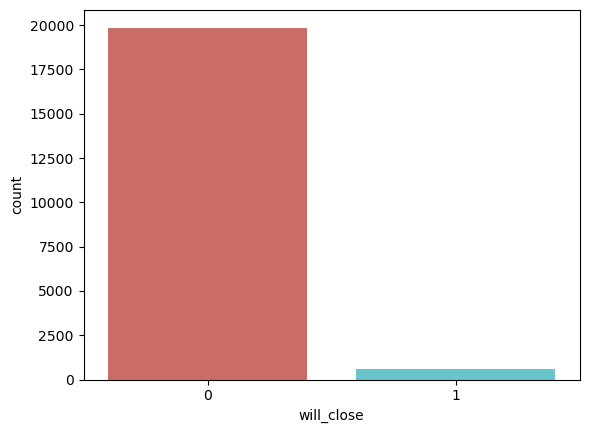

In [ ]:
# Fazendo gráfico de barras para a variável "will_close":
sns.countplot(x='will_close', data=df2, palette='hls')
plt.show()


### 5.1.2. Variável Numérica

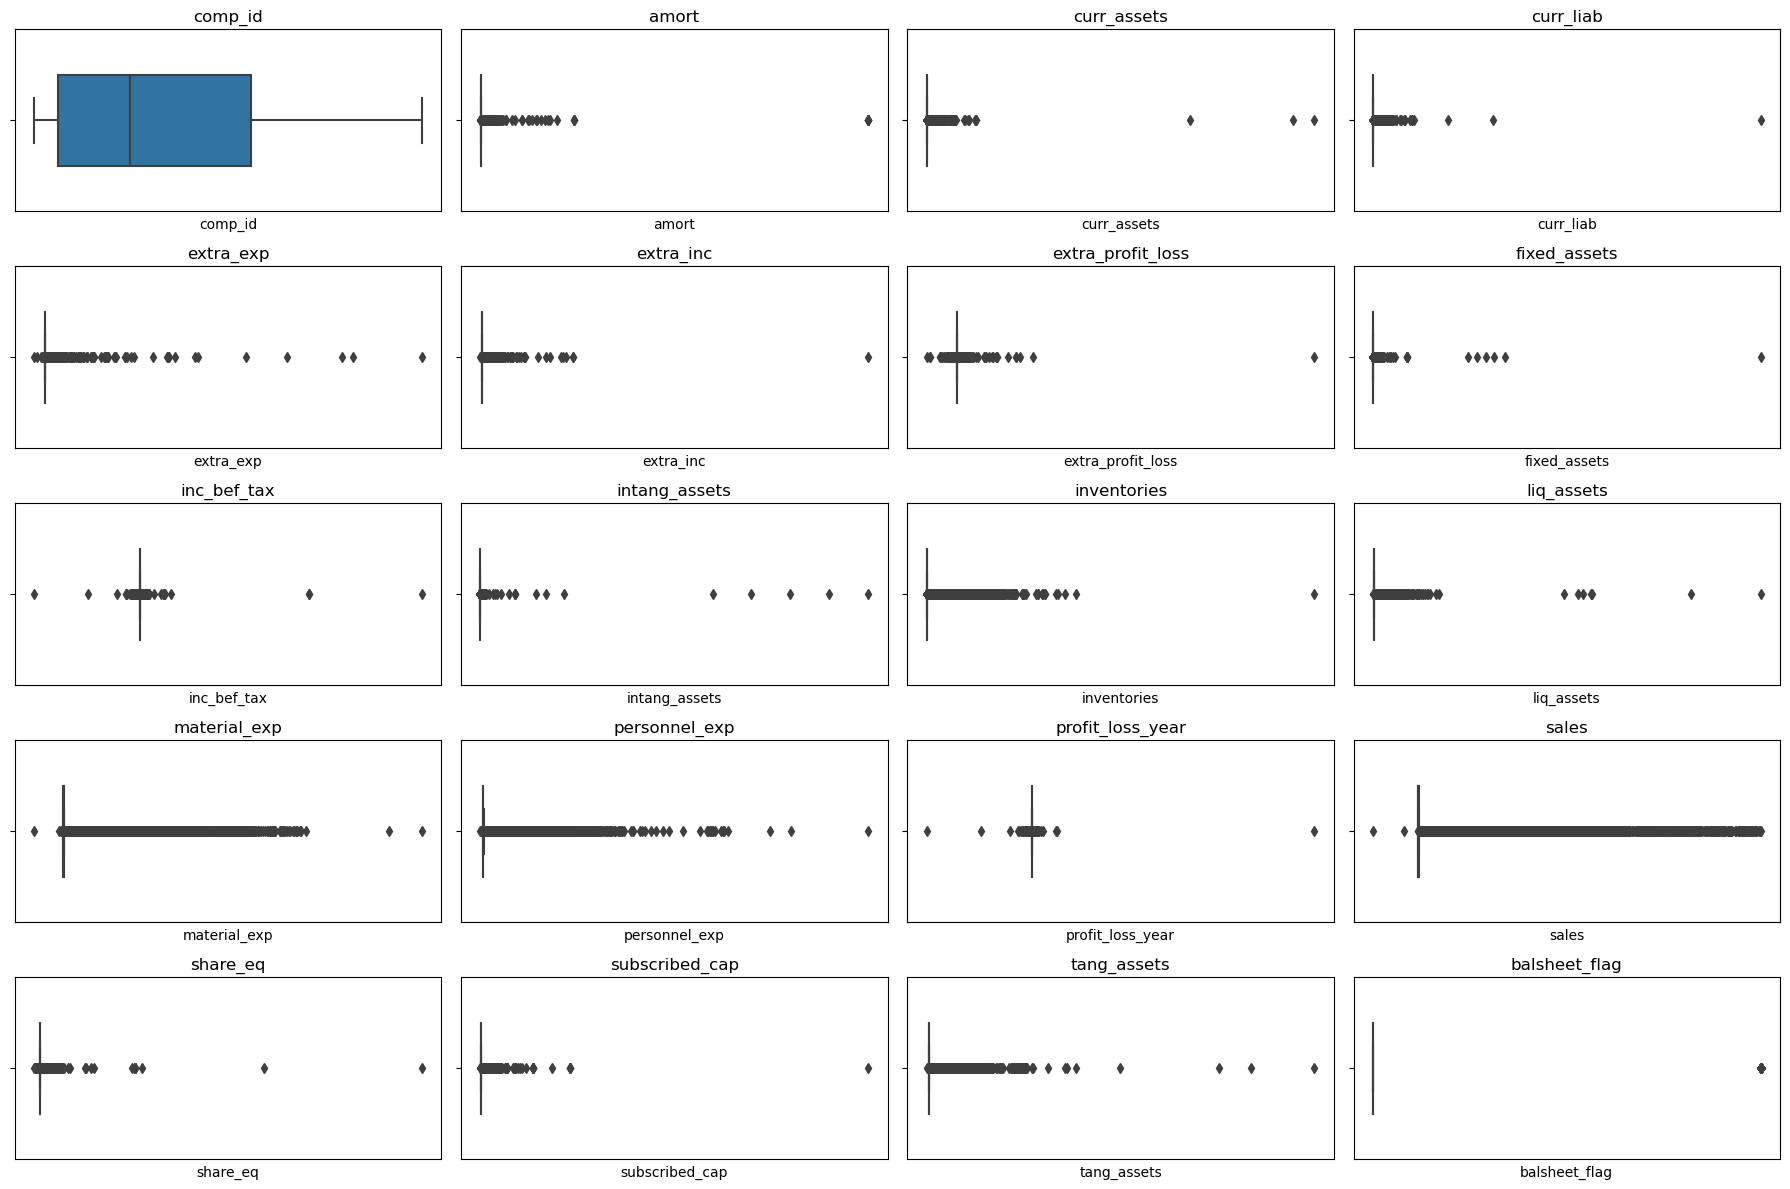

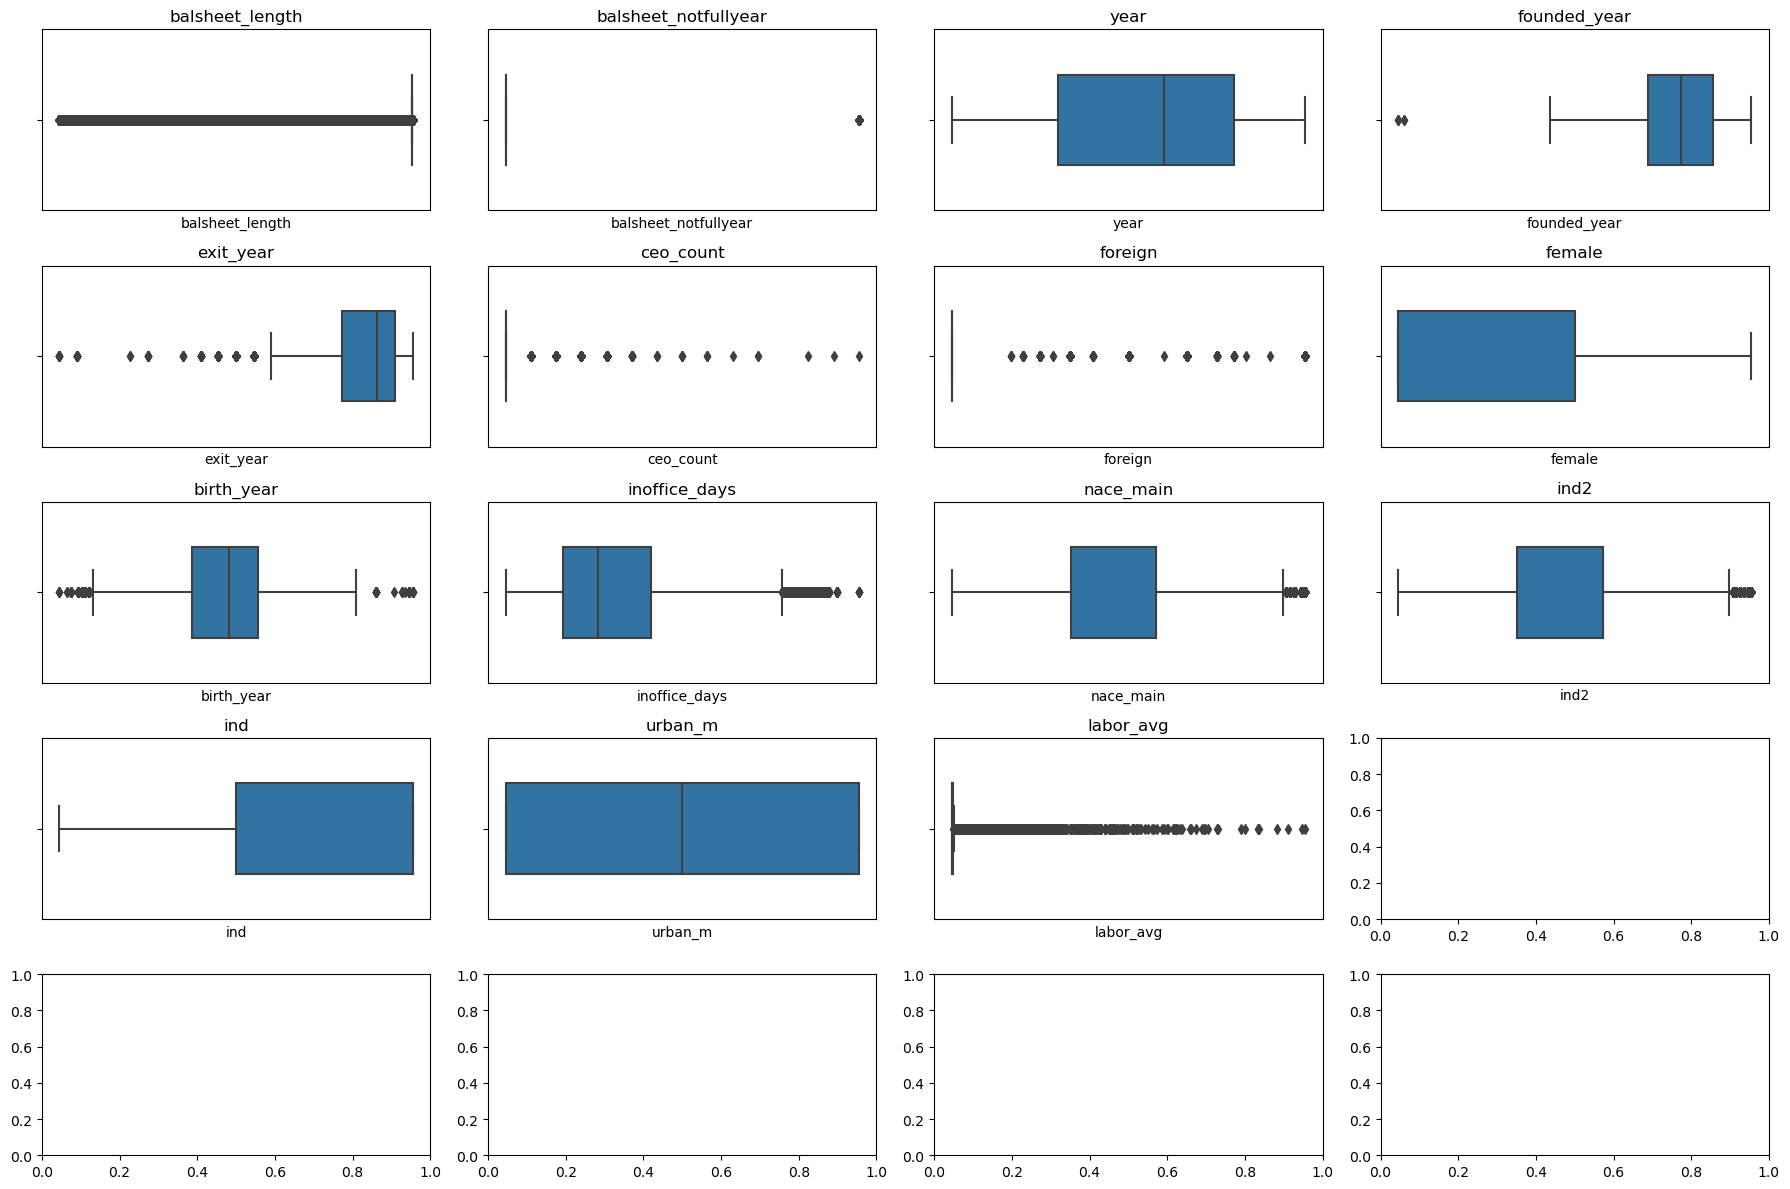

In [ ]:
# fazendo boxplot de todas as variáveis numéricas para identificar as distribuições:

colunas = var_num.columns

# Configurações para a disposição dos subplots
num_linhas = 5  
num_colunas = 4  

# Calcula o número total de figuras necessárias
num_total_figuras = (len(colunas) // (num_linhas * num_colunas)) + 1

# Tamanho da figura
tamanho_figura = (18, 12)

# Loop para criar cada figura com os boxplots
for figura_num in range(num_total_figuras):
    fig, axs = plt.subplots(num_linhas, num_colunas, figsize=tamanho_figura)
    
    # Colunas para esta figura
    inicio_coluna = figura_num * num_linhas * num_colunas
    fim_coluna = (figura_num + 1) * num_linhas * num_colunas
    colunas_figura = colunas[inicio_coluna:fim_coluna]

    # Iterar pelas colunas e criar os boxplots para esta figura
    for i, coluna in enumerate(colunas_figura):
        linha = i // num_colunas
        col = i % num_colunas
        sns.boxplot(x=var_num[coluna], ax=axs[linha, col], width=0.5)
        axs[linha, col].set_title(coluna)
        axs[linha, col].set_xticks([])  # Remove os rótulos do eixo x

    # Ajustar o layout
    plt.tight_layout()

    # Exibir a figura
    plt.show()

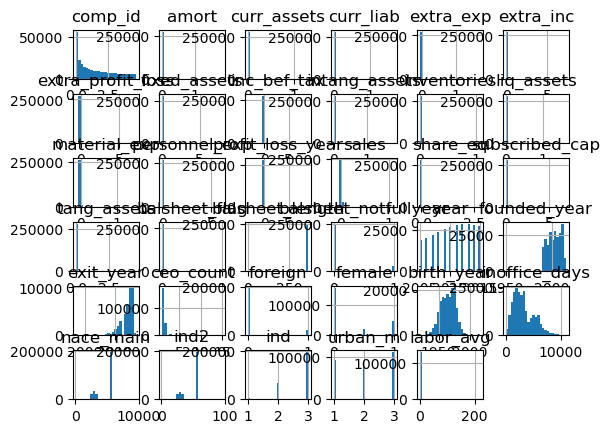

In [ ]:
var_num.hist( bins=25 )

### 5.1.3. Variável Categórica

## 5.2. Analise Bivariada

In [ ]:
# Fazer aqui análises que verificam se as hipóteses criadas são verdadeiras ou falsas. Isso nos ajudará a ter melhor intuição na utilização das variáveis no modelo,
# além de possibilitar que tenhamos um bom embasamento para utilizar na apresentação.

# PASSO 06 - DATA PREPARATION

## 6.1. Normalizacao

In [ ]:
# Aqui podemos verificar se há necessidade de codificação de variáveis, transofrmação em log, normalização, etc.

# PASSO 07 - SELEÇÃO DE VARIÁVEIS

## 7.1. Split do Dataframe entre Treino e Teste

# PASSO 08 - MODELAGEM DE MACHINE LEARNING


## 8.1. Modelo nulo - Média

## 8.2. Modelo de Regressão Linear

## 8.3. Modelo de Regressão Linear Regularizada - LASSO

## 8.4. Floresta Aleatória

## 8.5. Comparando performance